# Capstone Project - The Battle of Neighborhoods

In this capstone project, the analysis will focus on the the 

In [3]:
import requests
import folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

#### The data comes from https://data.tainan.gov.tw/dataset/landmark2/resource/0faea8ce-212e-40bd-861a-65f0d2789db6


In [4]:
with open('Tainan_attraction_data.json', encoding='utf-8-sig') as f:
        data = json.load(f)
        df=pd.DataFrame(data)

In [5]:
df.head()

,id,lang,name,summary,introduction,open_time,district,address,tel,fax,lat,long,services,category,update_time
0,4360,en,Koxinga Museum(鄭成功文物館),,Koxinga Museum(鄭成功文物館) is located inside&nbsp;...,"\r\nTuesday~Sunday 9:00~17:00, closed Monday a...",West Central Dist.,None,+886-6-2136207,,22.98737,120.20821,[],"[地方展館, 在地藝文]",2018-12-13 15:41:57
1,4361,en,KSK Church(看西街教會),,A church with a white dome that is a copy of S...,\r\n9:00~20:00 (Reservation needed before visit),West Central Dist.,None,+886-6-2225808,,22.99610,120.19853,[],"[歷史古蹟, 宗教廟宇, 在地藝文]",2018-12-13 15:41:57
2,4362,en,Puji Temple(普濟殿),,It is said that Tainan is shaped like a phoeni...,"\r\n7:00~21:00\r\nFree entry, open all year round",West Central Dist.,None,+886-6-2268774,,22.99897,120.19919,[],"[宗教廟宇, 在地藝文]",2018-12-13 15:41:57
3,4363,en,Shuixian Temple(水仙宮),,Many people will begin to feel hungry when the...,"\r\n7:00~17:00\r\nFree entry, open all year round",West Central Dist.,None,+886-6-2267151,,22.99679,120.19821,[],"[歷史古蹟, 宗教廟宇, 在地藝文]",2018-12-13 15:41:57
4,4364,en,Tainan Dehua Hall (臺南德化堂),,Dehua Hall (德化堂) was built around 1838. After ...,\r\nMonday-Sunday\r\n00:00~24:00,West Central Dist.,None,+886-6-2267151,,22.98911,120.20602,[],"[歷史古蹟, 宗教廟宇, 在地藝文]",2018-12-13 15:41:57


In [6]:
##drop irrelevant data
df=df.drop(columns=["open_time", "tel", "fax","id","lang","summary","introduction", "services", "update_time", "category","address"])

In [7]:
##check if there is missing value
df.count()

name        478
district    478
lat         477
long        477
dtype: int64

In [8]:
df = df[df.long.isna() == False]

In [9]:
df.head()

,name,district,lat,long
0,Koxinga Museum(鄭成功文物館),West Central Dist.,22.98737,120.20821
1,KSK Church(看西街教會),West Central Dist.,22.99610,120.19853
2,Puji Temple(普濟殿),West Central Dist.,22.99897,120.19919
3,Shuixian Temple(水仙宮),West Central Dist.,22.99679,120.19821
4,Tainan Dehua Hall (臺南德化堂),West Central Dist.,22.98911,120.20602


In [10]:
##check again
df.count()

name        477
district    477
lat         477
long        477
dtype: int64

## Explore Foursquare API

In [1]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


# Exploratory Data Analysis
## Visualizing the geospatial data

In [12]:
address = 'Tainan, Taiwan'

geolocator = Nominatim(user_agent="ta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tainan City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tainan City are 22.9912348, 120.184982.


In [13]:
map_tainan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df['lat'], df['long'], df['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tainan)  
    
map_tainan

### By visualizing the geospatial data, it is clear that the tourist attractions concentrated in the center of Tainan city.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
df_venue=getNearbyVenues(names=df['name'],
                                   latitudes=df['lat'],
                                   longitudes=df['long']
                                  )

Koxinga Museum(鄭成功文物館)
KSK Church(看西街教會)
Puji Temple(普濟殿)
Shuixian Temple(水仙宮)
Tainan Dehua Hall (臺南德化堂)
Chen De Jiu Family Hall(陳德聚堂)
Mrs  Xiao's Chastity Archway(蕭氏節孝坊)
God of Wind (Feng Shen) Temple(風神廟)
Wanfu Temple Wall(萬福庵照牆)
Jingfu Temple(景福祠)
Taiwan Fucheng City Wall South Gate Section remains (臺灣府城城垣南門段殘蹟)
Kaiji Ling You Temple(開基靈祐宮)
Zhonggan Temple(總趕宮)
Official Reception Stone Arch(接官亭)
Dongyue Temple(東嶽殿)
Taiwan’s First Temple of Heaven (Tiangong Temple)(臺灣首廟天壇(天公廟))
Tainan Story Image Museum (Former Koxinga Ancestral Temple)(臺南故事影像館(原鄭成功祖廟))
Fahua Temple(法華寺)
Judicial Museum (Former Tainan District Court)(司法博物館(原台南地方法院))
Dui Yue Gate(兌悅門)
Taiwanfu Cheng Huang (City God) Temple(臺灣府城隍廟)
Museum of MeteorologyFormer Tainan Meteorological Station (Central Weather Bureau Southern Region Weather Center) (原台南測候所(中央氣象局臺灣南區氣象中心))
Tainan City Council History Museum (Former Tainan Prefectural Council)(台南市議政史料館(原台南州會))
Jinhua Temple(金華府)
West Market (Wholesale Market)(西市場(大菜市))
Qianca

Ten Drum Culture Village(十鼓仁糖文創園區)
Bao-an Train Station(保安車站)
Chimei Museum(奇美博物館)
The Furniture Manufacturing Eco Museum in Tainan(臺南家具產業博物館)
Tainan Metropolitan Park(台南都會公園)
Alexander Butterfly Ecology Farm(亞力山大蝴蝶生態教育農場)
Chimei Happiness Factory(奇美食品幸福工廠)
Home Tech Hydrogel Tourism Factory(虹泰水凝膠世界)
Nan Yi Golf Country Club(南一高爾夫球場)
Guanmiao Shanxi Temple(關廟山西宮)
Chiefsun Puti Temple(千佛山菩提寺)
Wanglai Park (Da Tan Pi)(旺萊公園(大潭埤))
Niupu Farm Pond (牛埔農塘)
Dragon Boat Nest(龍船窩)
Huxingshan Park(虎形山公園)
Bamboo Charcoal Story Museum(竹炭故事館)
Longqi Wenheng Temple(龍崎文衡殿)
Guantian Jacana Ecological Education Park(官田水雉生態教育園區)
Yoichi Hatta Memorial Park(八田與一紀念園區)
Tainan National University of the Arts(台南藝術大學)
The Wonderful Tenergy Place(天一中藥生活化園區)
Chianan Golf Course(嘉南高爾夫球場)
Tainan Duck Leisure Farm(台南鴨莊休閒農場)
Wushantou Reservoir Scenic Area(烏山頭水庫風景區)
Longtian DistilleryCordyceps militaris Cultural Park(隆田酒廠北蟲草文化展示園區)
Lingpo Suspension Bridge(凌波吊橋)
Hulupi Nature Park(葫蘆埤自然公園)
Madou Datian Temple(麻豆代天府)

Dujia Settlement Artefacts Museum (篤加聚落文物展覽館)
Taijian National Park Administration: Visitor Center & Administration Center Park(台江國家公園管理處遊客中心暨行政中心園區)
Junshi Legend(金獅傳說)
Zuojhen Moon Wor Ecological Academy (Ganglin Elementary School) (左鎮月世界生態學園(岡林國小))
Chen Yung Hua Tomb (Viceroy and Lady Chen Yong Hua Tomb)(陳永華墓(陳永華總制夫婦古墓))
Licence Art Gallery(東門美術館)
Luermen History and Culture Region Community Culture Museum(鹿耳門歷史文化區域地方文化館)
Xingan Community Culture Museum(新港社地方文化館)
Chihkan Culture Park(赤嵌文化園區) 
Tainan City Nanying Hakka Culture Museum(臺南市南瀛客家文化會館)
Mangrove Bird-Watching Area(紅樹林賞鳥區)
Taijiang Ecological Culture Zone(台江生態文化園區)
Old Tainan City Remains (Fort Zeelandia Interior Wall)(臺灣城殘蹟(安平古堡內牆))
Madou Culture Museum(麻豆文化館)
Puh-b Plain Indigenous Culture Museum (拔馬平埔文物館)
Madou Lin Shu Xing’s Residence(麻豆林家四房厝)
Dongshan Niurouqi Police Station(東山牛肉崎警察官吏派出所)
Japanese Style Dormitories of Formerly Tainan School of Agriculture(原台南農校日式宿舍群)
Furongpi Ecological Park(芙蓉埤生態園區)
Kunshan Lake (Jiyu 

In [17]:
df_venue.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Koxinga Museum(鄭成功文物館),22.98737,120.20821,延平郡王祠 Koxinga Temple,22.988023,120.207959,Temple
1,Koxinga Museum(鄭成功文物館),22.98737,120.20821,Yaoping (堯平布朗尼工作室),22.989384,120.206864,Dessert Shop
2,Koxinga Museum(鄭成功文物館),22.98737,120.20821,Sunice (太陽牌冰品),22.989615,120.210392,Ice Cream Shop
3,Koxinga Museum(鄭成功文物館),22.98737,120.20821,阿和肉燥飯,22.988934,120.210664,Taiwanese Restaurant
4,Koxinga Museum(鄭成功文物館),22.98737,120.20821,阿龍意麵,22.988967,120.209533,Noodle House
5,Koxinga Museum(鄭成功文物館),22.98737,120.20821,順風號,22.990220,120.207902,Café
6,Koxinga Museum(鄭成功文物館),22.98737,120.20821,孔廟,22.990089,120.204508,Historic Site
7,Koxinga Museum(鄭成功文物館),22.98737,120.20821,EVA伊娃日式泡芙專賣店,22.984504,120.205597,Dessert Shop
8,Koxinga Museum(鄭成功文物館),22.98737,120.20821,山記魚仔店,22.988940,120.208094,Seafood Restaurant
9,Koxinga Museum(鄭成功文物館),22.98737,120.20821,克林台包,22.989106,120.204581,Dumpling Restaurant


#### No. of venues were returned for each neighborhood

In [18]:
dfgroup=df_venue.groupby('Neighborhood').count()

#### how many unique categories can be curated from all the returned venues?

In [19]:
print('There are {} uniques categories.'.format(len(df_venue['Venue Category'].unique())))

There are 173 uniques categories.



#### use one-hot encoding technique to order categories

In [20]:
# one hot encoding
tainan_onehot = pd.get_dummies(df_venue[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tainan_onehot['Neighborhood'] = df_venue['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tainan_onehot.columns[-1]] + list(tainan_onehot.columns[:-1])
tainan_onehot = tainan_onehot[fixed_columns]

tainan_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Theme Park,Theme Restaurant,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Water Park,Whisky Bar,Zoo
0,Koxinga Museum(鄭成功文物館),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Koxinga Museum(鄭成功文物館),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Koxinga Museum(鄭成功文物館),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Koxinga Museum(鄭成功文物館),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Koxinga Museum(鄭成功文物館),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
tainan_onehot.shape

(5009, 174)

#### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
tainan_grouped = tainan_onehot.groupby('Neighborhood').mean().reset_index()
print(tainan_grouped.head())

                                        Neighborhood  Accessories Store  \
0  1934 Historic Restaurant at Xinhua District Co...                0.0   
1     Alexander Butterfly Ecology Farm(亞力山大蝴蝶生態教育農場)                0.0   
2             Ancient Mansion of the Su Family(蘇家古厝)                0.0   
3                         Anping Canal Tours(台南運河遊船)                0.0   
4                   Anping Catholic Museum(安平天主教文物館)                0.0   

   American Restaurant  Arcade  Art Gallery  Art Museum  Arts & Crafts Store  \
0                  0.0     0.0          0.0         0.0                  0.0   
1                  0.0     0.0          0.0         0.0                  0.0   
2                  0.0     0.0          0.0         0.0                  0.0   
3                  0.0     0.0          0.0         0.0                  0.0   
4                  0.0     0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Workshop  ...  Theme P

In [23]:
num_top_venues = 5

for hood in tainan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tainan_grouped[tainan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1934 Historic Restaurant at Xinhua District Council House(新化街役場1934街役場古蹟餐坊)----
                           venue  freq
0                           Café  0.50
1                    Bus Station  0.25
2               Asian Restaurant  0.25
3  Paper / Office Supplies Store  0.00
4                  National Park  0.00


----Alexander Butterfly Ecology Farm(亞力山大蝴蝶生態教育農場)----
                           venue  freq
0               Asian Restaurant   1.0
1              Accessories Store   0.0
2  Paper / Office Supplies Store   0.0
3                  National Park   0.0
4                Nature Preserve   0.0


----Ancient Mansion of the Su Family(蘇家古厝)----
            venue  freq
0            Café   0.2
1            Road   0.2
2  History Museum   0.2
3   Historic Site   0.2
4     Bus Station   0.2


----Anping Canal Tours(台南運河遊船)----
                venue  freq
0  Seafood Restaurant  0.14
1        Dessert Shop  0.14
2  Chinese Restaurant  0.14
3       Historic Site  0.07
4         Snack Place

            venue  freq
0            Café  0.12
1      Steakhouse  0.12
2          Bakery  0.12
3      Restaurant  0.06
4  Breakfast Spot  0.06


----Chianan Golf Course(嘉南高爾夫球場)----
               venue  freq
0        Golf Course   1.0
1  Accessories Store   0.0
2          Multiplex   0.0
3        Music Venue   0.0
4      National Park   0.0


----Chianan Management Office, Irrigation Agency (Former Chianan Irrigation Channel Cooperative Office) (農田水利署嘉南管理處(原嘉南大圳組合事務所) )----
                  venue  freq
0  Taiwanese Restaurant  0.10
1                  Café  0.10
2    Chinese Restaurant  0.08
3          Noodle House  0.08
4           Coffee Shop  0.05


----Chihkan Culture Park(赤嵌文化園區) ----
                  venue  freq
0  Taiwanese Restaurant  0.21
1          Dessert Shop  0.12
2          Noodle House  0.07
3        Ice Cream Shop  0.05
4    Chinese Restaurant  0.05


----Chikan Tower(赤嵌樓)----
                  venue  freq
0  Taiwanese Restaurant  0.19
1                  Café  0.11
2

               venue  freq
0               Café   0.5
1     Scenic Lookout   0.5
2  Accessories Store   0.0
3             Palace   0.0
4      National Park   0.0


----Former Julius Mannich & CO (原德商東興洋行)----
               venue  freq
0      Historic Site  0.16
1     History Museum  0.16
2       Dessert Shop  0.16
3               Café  0.05
4  Food & Drink Shop  0.05


----Former Official Residence of the Mayor of Tainan(原台南廳長官邸)----
               venue  freq
0       Noodle House  0.10
1  Convenience Store  0.10
2     Breakfast Spot  0.10
3                Bar  0.05
4        Coffee Shop  0.05


----Former Tainan He Tong Building(Tainan City Fire Museum)(原台南合同廳舍)(消防史料館)----
                  venue  freq
0  Taiwanese Restaurant  0.10
1                  Café  0.08
2          Noodle House  0.07
3   Japanese Restaurant  0.07
4           Coffee Shop  0.07


----Former Tainan Park Management Office(原台南公園管理所)----
         venue  freq
0        Hotel  0.13
1         Café  0.09
2  Bus Station  0

               venue  freq
0               Park   0.6
1              Hotel   0.4
2  Accessories Store   0.0
3             Palace   0.0
4        Music Venue   0.0


----Houbi Togo Art Museum(後壁土溝農村美術館)----
               venue  freq
0        Art Gallery   0.5
1               Farm   0.5
2  Accessories Store   0.0
3               Park   0.0
4    Nature Preserve   0.0


----Houbi Train Station(後壁車站)----
                           venue  freq
0                       Platform  0.50
1                         Buffet  0.25
2                  Deli / Bodega  0.25
3  Paper / Office Supplies Store  0.00
4                  National Park  0.00


----Houbi Wumiler Community(後壁無米樂社區)----
                  venue  freq
0        Ice Cream Shop   0.2
1            Water Park   0.2
2        Farmers Market   0.2
3  Taiwanese Restaurant   0.2
4         Historic Site   0.2


----Houjia Guan Di Temple(後甲關帝殿)----
                  venue  freq
0  Taiwanese Restaurant  0.50
1      Asian Restaurant  0.25
2       Bed

              venue  freq
0              Café  0.33
1       Coffee Shop  0.22
2      Night Market  0.11
3  Asian Restaurant  0.11
4      Noodle House  0.11


----Lady Linshui Temple(臨水夫人廟)----
                  venue  freq
0  Taiwanese Restaurant  0.19
1          Dessert Shop  0.11
2                  Café  0.11
3        Ice Cream Shop  0.07
4          Noodle House  0.07


----Lao Tang Lake Art Village(老塘湖藝術村)----
                           venue  freq
0                         Palace   1.0
1              Accessories Store   0.0
2  Paper / Office Supplies Store   0.0
3                  National Park   0.0
4                Nature Preserve   0.0


----Licence Art Gallery(東門美術館)----
                  venue  freq
0                  Café  0.16
1  Taiwanese Restaurant  0.09
2          Dessert Shop  0.06
3   Japanese Restaurant  0.06
4     Accessories Store  0.03


----Lin Kun-gang Memorial Hall(林崑岡紀念館)----
                           venue  freq
0                 Ice Cream Shop   0.6
1        

                           venue  freq
0                         Garden  0.33
1                          Hotel  0.33
2              Convenience Store  0.33
3  Paper / Office Supplies Store  0.00
4                  National Park  0.00


----Nanwan Wharf Recreation Area (南灣碼頭遊憩區)----
                           venue  freq
0                           Pier   1.0
1              Accessories Store   0.0
2  Paper / Office Supplies Store   0.0
3                  National Park   0.0
4                Nature Preserve   0.0


----Nanying Green Heart Park (No.5 Park)(南瀛綠都心5號公園)----
                   venue  freq
0   Taiwanese Restaurant  0.22
1                  Diner  0.11
2  Performing Arts Venue  0.11
3                   Café  0.11
4             Food Truck  0.11


----National Cheng Kung University Banyan Park(成大榕園)----
                  venue  freq
0            Steakhouse  0.12
1                  Café  0.12
2                Bakery  0.12
3                Hostel  0.06
4  Fast Food Restaurant  0.06


                venue  freq
0      Breakfast Spot  0.25
1  Athletics & Sports  0.25
2   Convenience Store  0.25
3            Tea Room  0.25
4   Accessories Store  0.00


----Shuixian Temple(水仙宮)----
                  venue  freq
0  Taiwanese Restaurant  0.14
1         Historic Site  0.08
2          Dessert Shop  0.08
3        Ice Cream Shop  0.06
4          Noodle House  0.06


----Siaobei Night Market(小北觀光夜市)----
                  venue  freq
0  Taiwanese Restaurant  0.29
1      Ramen Restaurant  0.14
2      Asian Restaurant  0.14
3  Fast Food Restaurant  0.14
4   Fried Chicken Joint  0.14


----Sicao Artillery Fort(四草砲台)----
                           venue  freq
0                  National Park  0.25
1                  Boat or Ferry  0.25
2                           Lake  0.25
3                 History Museum  0.25
4  Paper / Office Supplies Store  0.00


----Sicao Dazhong Temple(四草大眾廟)----
                  venue  freq
0            Soup Place  0.25
1      Asian Restaurant  0.25
2  

                  venue  freq
0  Taiwanese Restaurant  0.11
1                  Café  0.10
2          Noodle House  0.08
3           Coffee Shop  0.08
4   Japanese Restaurant  0.06


----Tainan Fire Department Disaster Prevention Education Hall (臺南市政府消防局防災教育館)----
                           venue  freq
0             Italian Restaurant  0.33
1              Convenience Store  0.33
2             Seafood Restaurant  0.33
3              Accessories Store  0.00
4  Paper / Office Supplies Store  0.00


----Tainan Great South Gate(臺灣府城大南門)----
                  venue  freq
0  Taiwanese Restaurant  0.21
1          Dessert Shop  0.12
2          Noodle House  0.07
3        Ice Cream Shop  0.05
4    Chinese Restaurant  0.05


----Taisugar Wushulin Park(台糖烏樹林園區)----
               venue  freq
0      Train Station  0.67
1         Theme Park  0.33
2  Accessories Store  0.00
3             Palace  0.00
4        Music Venue  0.00


----Taiwan Blackfoot Disease Socio-Medical Service Memorial House(烏腳病紀念館)

4      National Park   0.0


----Wuchengen Park(武承恩公園)----
                 venue  freq
0           Street Art  0.33
1        Grocery Store  0.33
2  Fried Chicken Joint  0.33
3    Accessories Store  0.00
4    Outdoor Sculpture  0.00


----Wufei Temple(五妃廟)----
                venue  freq
0        Dessert Shop  0.36
1   Convenience Store  0.14
2        Burger Joint  0.07
3         Pizza Place  0.07
4  Athletics & Sports  0.07


----Xi Hua Hall(西華堂)----
              venue  freq
0             Hotel  0.15
1  Department Store  0.07
2       Bus Station  0.07
3              Café  0.04
4   Thai Restaurant  0.04


----Xianzu Temple (Ziyun Temple)(仙祖廟(紫雲殿))----
                  venue  freq
0            Hot Spring   0.6
1  Taiwanese Restaurant   0.2
2  Other Great Outdoors   0.2
3     Accessories Store   0.0
4                Palace   0.0


----Xiaonan Sea Scenic Area(小南海風景區)----
                      venue  freq
0                Food Stand  0.25
1                      Lake  0.25
2  Bike Rental 

                           venue  freq
0                           Café  0.50
1                          Diner  0.25
2             Chinese Restaurant  0.25
3  Paper / Office Supplies Store  0.00
4                Nature Preserve  0.00


----Yuejin Harbor Water Park(月津港親水公園)----
           venue  freq
0   Noodle House   0.4
1   Dessert Shop   0.2
2           Lake   0.2
3  Historic Site   0.2
4           Park   0.0


----Yuejin Harbor- Jubo Pavilion- Dazhong Temple (月津港-聚波亭大眾廟)----
                 venue  freq
0         Noodle House  0.33
1  Indie Movie Theater  0.17
2         Dessert Shop  0.17
3   Chinese Restaurant  0.17
4        Historic Site  0.17


----Yuguang Island(漁光島)----
                           venue  freq
0                         Island   0.5
1                          Beach   0.5
2              Accessories Store   0.0
3  Paper / Office Supplies Store   0.0
4                  National Park   0.0


----Yujing Beiji Temple(玉井北極殿)----
               venue  freq
0     Ice Crea

#### write a function to sort the venues in descending order.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### create the new dataframe and display the top 10 venues for each neighborhood.

In [81]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tainan_grouped['Neighborhood']

for ind in np.arange(tainan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tainan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1934 Historic Restaurant at Xinhua District Co...,Café,Bus Station,Asian Restaurant,Zoo,Fishing Spot,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
1,Alexander Butterfly Ecology Farm(亞力山大蝴蝶生態教育農場),Asian Restaurant,Zoo,Fish & Chips Shop,Food Truck,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
2,Ancient Mansion of the Su Family(蘇家古厝),Road,History Museum,Café,Historic Site,Bus Station,Dumpling Restaurant,Donut Shop,Food Court,Food & Drink Shop,Diner
3,Anping Canal Tours(台南運河遊船),Dessert Shop,Seafood Restaurant,Chinese Restaurant,Fast Food Restaurant,Food & Drink Shop,Snack Place,Museum,Soup Place,Dim Sum Restaurant,Convenience Store
4,Anping Catholic Museum(安平天主教文物館),Dessert Shop,History Museum,Historic Site,Soup Place,Boat or Ferry,Convenience Store,Chinese Restaurant,Seafood Restaurant,Café,Museum


# Cluster Neighborhood

In [135]:
##find the optimal number of clusters
Sum_of_squared_dist = []
K = range(1,10)
tainan_grouped_clustering = tainan_grouped.drop('Neighborhood', 1)
for k in K:
    km_elbow = KMeans(n_clusters=k).fit(tainan_grouped_clustering)
    Sum_of_squared_dist.append(km_elbow.inertia_)

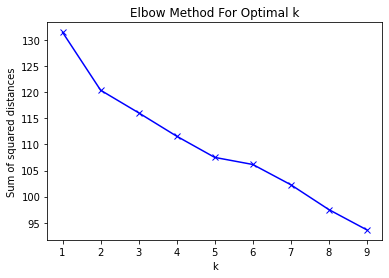

In [136]:
plt.plot(K, Sum_of_squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Run k-means to cluster the neighborhood into 10 clusters.

In [137]:
# set number of clusters
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit( tainan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

#### create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [138]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df2=df.rename(columns = {'name':'Neighborhood'})
df_merged = df2

# merge df_grouped with df(origin dataset) to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_merged.head() 

,Neighborhood,district,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Koxinga Museum(鄭成功文物館),West Central Dist.,22.98737,120.20821,2.0,Taiwanese Restaurant,Dessert Shop,Café,Noodle House,Temple,Dumpling Restaurant,Chinese Restaurant,Flea Market,Seafood Restaurant,Snack Place
1,KSK Church(看西街教會),West Central Dist.,22.99610,120.19853,2.0,Taiwanese Restaurant,Dessert Shop,Noodle House,Historic Site,Seafood Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Juice Bar,Bubble Tea Shop
2,Puji Temple(普濟殿),West Central Dist.,22.99897,120.19919,2.0,Taiwanese Restaurant,Historic Site,Café,Noodle House,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Bar,Cocktail Bar,Restaurant
3,Shuixian Temple(水仙宮),West Central Dist.,22.99679,120.19821,2.0,Taiwanese Restaurant,Dessert Shop,Historic Site,Noodle House,Seafood Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Juice Bar,Fast Food Restaurant
4,Tainan Dehua Hall (臺南德化堂),West Central Dist.,22.98911,120.20602,2.0,Taiwanese Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Dessert Shop,Noodle House,Accessories Store,Historic Site,Seafood Restaurant,Department Store


# Visualization

In [145]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['lat'], df_merged['long'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if not pd.isna(cluster):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)],
            fill=True,
            fill_color=rainbow[int(cluster)],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine each cluster and determine the discriminating venue categories that distinguish each cluste

In [140]:
#Cluster 1
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,East Dist.,Café,Bakery,Steakhouse,Japanese Restaurant,Fast Food Restaurant,Coffee Shop,Noodle House,Breakfast Spot,Convenience Store,Sandwich Place
66,East Dist.,Department Store,Asian Restaurant,Bookstore,Coffee Shop,Tea Room,Paper / Office Supplies Store,Italian Restaurant,Fast Food Restaurant,Cultural Center,Hotel
67,East Dist.,Movie Theater,Snack Place,Breakfast Spot,Japanese Restaurant,BBQ Joint,Fishing Spot,Food Truck,Food Stand,Food Court,Food & Drink Shop
73,East Dist.,Breakfast Spot,Convenience Store,Noodle House,Steakhouse,Coffee Shop,Bubble Tea Shop,Café,Bar,Bakery,Japanese Restaurant
76,East Dist.,Café,Steakhouse,Bakery,Japanese Restaurant,Food,Breakfast Spot,Sandwich Place,Coffee Shop,Restaurant,Convenience Store
...,...,...,...,...,...,...,...,...,...,...,...
454,Xiaying Dist.,Fried Chicken Joint,Street Art,Grocery Store,Zoo,Fish & Chips Shop,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
455,Yongkang Dist.,Tea Room,Sushi Restaurant,Hotpot Restaurant,Intersection,Asian Restaurant,BBQ Joint,Chinese Restaurant,Shopping Mall,Supermarket,Food Court
458,Anping Dist.,Bus Stop,Beach,Harbor / Marina,Zoo,Fish & Chips Shop,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
470,Xiaying Dist.,Restaurant,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot


In [141]:
#Cluster 2
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
132,Annan Dist.,Park,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot
206,Guanmiao Dist.,Park,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot
213,Guantian Dist.,Park,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot
220,Guantian Dist.,Park,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot
221,Guantian Dist.,Park,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot
231,Qigu Dist.,Boat or Ferry,Park,Zoo,Fish & Chips Shop,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
236,Qigu Dist.,Boat or Ferry,Park,Zoo,Fish & Chips Shop,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
300,Baihe Dist.,Park,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot
304,Baihe Dist.,Park,Hotel,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
317,Liujia Dist.,Park,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fishing Spot


In [142]:
#Cluster 3
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Central Dist.,Taiwanese Restaurant,Dessert Shop,Café,Noodle House,Temple,Dumpling Restaurant,Chinese Restaurant,Flea Market,Seafood Restaurant,Snack Place
1,West Central Dist.,Taiwanese Restaurant,Dessert Shop,Noodle House,Historic Site,Seafood Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Juice Bar,Bubble Tea Shop
2,West Central Dist.,Taiwanese Restaurant,Historic Site,Café,Noodle House,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Bar,Cocktail Bar,Restaurant
3,West Central Dist.,Taiwanese Restaurant,Dessert Shop,Historic Site,Noodle House,Seafood Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Juice Bar,Fast Food Restaurant
4,West Central Dist.,Taiwanese Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Dessert Shop,Noodle House,Accessories Store,Historic Site,Seafood Restaurant,Department Store
...,...,...,...,...,...,...,...,...,...,...,...
463,East Dist.,Noodle House,Bagel Shop,Café,Music Venue,Taiwanese Restaurant,Bubble Tea Shop,Farm,Farmers Market,Food Stand,Food Court
465,East Dist.,Café,Coffee Shop,Chinese Restaurant,Taiwanese Restaurant,Noodle House,Japanese Restaurant,Bagel Shop,Bar,Food Court,Food & Drink Shop
471,West Central Dist.,Taiwanese Restaurant,Noodle House,Dessert Shop,Historic Site,Seafood Restaurant,Café,Chinese Restaurant,Ice Cream Shop,Juice Bar,Bubble Tea Shop
475,West Central Dist.,Taiwanese Restaurant,Café,Chinese Restaurant,Tea Room,Ice Cream Shop,Art Museum,Coffee Shop,Dessert Shop,Noodle House,Accessories Store


In [143]:
#Cluster 4
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,South Dist.,Beach,Zoo,French Restaurant,Food Truck,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
82,South Dist.,Beach,Zoo,French Restaurant,Food Truck,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
87,South Dist.,Beach,Zoo,French Restaurant,Food Truck,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
90,South Dist.,Beach,Park,Zoo,Fish & Chips Shop,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
121,Anping Dist.,Beach,Lighthouse,Bus Stop,Harbor / Marina,Fish & Chips Shop,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
244,Jiangjun Dist.,Beach,Zoo,French Restaurant,Food Truck,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
245,Jiangjun Dist.,Beach,Seafood Restaurant,Zoo,Forest,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
255,Beimen Dist.,Beach,Bathing Area,Zoo,Fishing Spot,Food Truck,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop
358,Anping Dist.,Island,Beach,Zoo,Fish & Chips Shop,Food Truck,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop


In [144]:
#Cluster 5
df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,West Central Dist.,Dessert Shop,Café,Convenience Store,Taiwanese Restaurant,Pizza Place,Grocery Store,Seafood Restaurant,Sculpture Garden,Chinese Restaurant,Temple
17,West Central Dist.,Dessert Shop,Café,Fried Chicken Joint,Bubble Tea Shop,Donut Shop,Flower Shop,Food Truck,Diner,Food Stand,Food Court
26,West Central Dist.,Dessert Shop,Taiwanese Restaurant,Temple,Convenience Store,Noodle House,Chinese Restaurant,Sculpture Garden,Seafood Restaurant,Fried Chicken Joint,Grocery Store
31,West Central Dist.,Dessert Shop,Café,Ice Cream Shop,BBQ Joint,Steakhouse,Taiwanese Restaurant,Noodle House,Temple,Resort,Middle Eastern Restaurant
37,West Central Dist.,Dessert Shop,Convenience Store,Pizza Place,Athletics & Sports,Sculpture Garden,Burger Joint,Grocery Store,Noodle House,Taiwanese Restaurant,Field
...,...,...,...,...,...,...,...,...,...,...,...
432,Anping Dist.,Historic Site,Dessert Shop,History Museum,Seafood Restaurant,Tapas Restaurant,Convenience Store,Chinese Restaurant,Café,Museum,Food & Drink Shop
434,Zuozhen Dist.,History Museum,BBQ Joint,Zoo,Field,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
457,Guiren Dist.,Convenience Store,Shoe Store,Chinese Restaurant,Zoo,Fish & Chips Shop,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
464,Anping Dist.,Historic Site,Dessert Shop,Seafood Restaurant,Food & Drink Shop,Tapas Restaurant,Soup Place,Monument / Landmark,Museum,Convenience Store,Chinese Restaurant
